In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn import ensemble
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict 
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import xgboost as xgb
import lightgbm as lgb

from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models, weight):
        self.models = models
        self.weight = weight

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    # Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
#        return np.mean(predictions, axis=1)      
        return self.weight*predictions[:,0] + (1-self.weight)*predictions[:,1] 

In [14]:
id = '51'

train = pd.read_csv('data/id_'+id+'_train.csv', sep=';')
test = pd.read_csv('data/id_'+id+'_test.csv', sep=';')

# Missing Data

In [15]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print missing_data.head(15)

if id == '51':
    train = train[1454:]   
train.drop(['wind_gust', 'lightning_risk',
                'measured_wind_gust', 'availability'], axis=1, inplace=True)

                         Total   Percent
measured_wind_gust        6769  1.000000
lightning_risk            6769  1.000000
wind_gust                 6769  1.000000
Power                     1454  0.214803
availability                 0  0.000000
measured_wind_direction      0  0.000000
measured_wind_speed          0  0.000000
precipitation                0  0.000000
temp                         0  0.000000
wind_direction               0  0.000000
wind_speed                   0  0.000000
predictiondate               0  0.000000


# Feature Engineering

Extract hour, day and month

In [16]:
# Feature Engineering
train['hour'] = train['predictiondate'].apply(lambda x: int(x[11:13]))
train['day'] = train['predictiondate'].apply(lambda x: int(x[:2]))
train['month'] = train['predictiondate'].apply(lambda x: int(x[3:5]))
test['hour'] = test['predictiondate'].apply(lambda x: int(x[11:13]))
test['day'] = test['predictiondate'].apply(lambda x: int(x[:2]))
test['month'] = test['predictiondate'].apply(lambda x: int(x[3:5]))


# Data Visualization

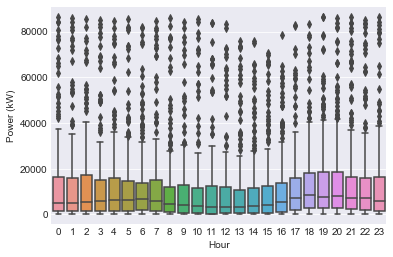

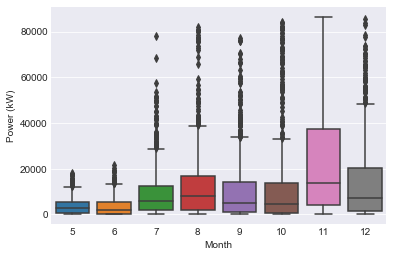

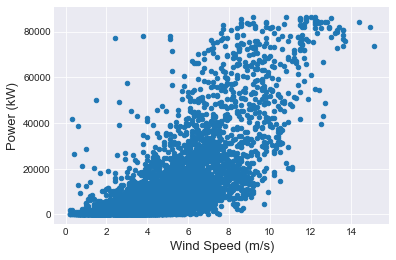

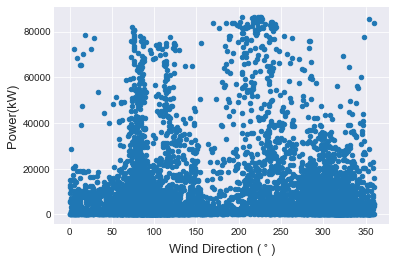

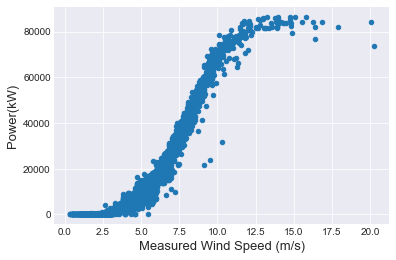

In [ ]:
plt.figure()
sns.boxplot(x='hour', y="Power", data=train)
plt.ylabel('Power (kW)')
plt.xlabel('Hour')

plt.figure()
sns.boxplot(x='month', y="Power", data=train)
plt.ylabel('Power (kW)')
plt.xlabel('Month')

plt.figure()
train.plot.scatter(x='wind_speed', y='Power')
plt.ylabel('Power (kW)', fontsize=13)
plt.xlabel('Wind Speed (m/s)', fontsize=13)

plt.figure()
train.plot.scatter(x='wind_direction', y='Power')
plt.ylabel('Power(kW)', fontsize=13)
plt.xlabel('Wind Direction ($^\circ$)', fontsize=13)

plt.figure()
train.plot.scatter(x='measured_wind_speed', y='Power')
plt.ylabel('Power(kW)', fontsize=13)
plt.xlabel('Measured Wind Speed (m/s)', fontsize=13)

plt.figure()
train.plot.scatter(x='measured_wind_direction', y='Power')
plt.ylabel('Power(kW)', fontsize=13)
plt.xlabel('Measured Wind Direction ($^\circ$)', fontsize=13)

plt.figure()
train.plot.scatter(x='precipitation', y='Power')    
plt.ylabel('Power(kW)', fontsize=13)
plt.xlabel('Precipitation (mm)', fontsize=13)

plt.figure()
train.plot.scatter(x='temp', y='Power')
plt.ylabel('Power(kW)', fontsize=13)
plt.xlabel('Temperature ($^\circ$C)', fontsize=13)

plt.figure()
train.plot.scatter(x='wind_speed', y='measured_wind_speed')
plt.ylabel('Measured Wind Speed (m/s)', fontsize=13)
plt.xlabel('Wind Speed (m/s)', fontsize=13)

plt.figure()
train.plot.scatter(x='wind_direction', y='measured_wind_direction')
plt.ylabel('Measured Wind Direction ($^\circ$)', fontsize=13)
plt.xlabel('Wind Direction ($^\circ$)', fontsize=13)

plt.figure()
sns.distplot(train['Power'])
plt.title('Power distribution')

plt.figure()
sns.distplot(train['wind_speed'])
plt.title('Wind Speed distribution')

plt.figure()
sns.distplot(train['wind_direction'])
plt.title('Wind Direction distribution')

#plt.figure()
#sns.distplot(train['precipitation'])
#plt.title('Precipitation distribution')

plt.figure()
sns.distplot(train['temp'])
plt.title('Temperature distribution')
    
plt.show()


In [ ]:
sns.heatmap(train.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

# Feature Selection 

In [ ]:
features = ['wind_speed', 'wind_direction', 'temp',
            'precipitation', 'hour', 'month']

max_power = train['Power'].max()
train['Power'] = train['Power'].divide(max_power)
print('Maximum Power: ' + str(max_power) + ' kW')

train, test_ = train_test_split(train, train_size=0.85, shuffle=False)
scaler = StandardScaler()
X_train = scaler.fit_transform(train[features].values)
y_train = np.array(train["Power"])
X_test = scaler.transform(test_[features].values)
y_test = np.array(test_["Power"])

model = lgb.LGBMRegressor()
rfe = RFECV(estimator=model, cv=10, step=1)
rfe = rfe.fit(X_train, y_train)
print rfe.support_

model = xgb.XGBRegressor()
rfe = RFECV(estimator=model, cv=10, step=1)
rfe = rfe.fit(X_train, y_train)
print rfe.support_

if id == '04':
    features = ['wind_speed', 'wind_direction', 'temp', 'hour']
elif id == '51':
    features = ['wind_speed', 'wind_direction', 'temp', 'hour', 'month']

# Data Modeling

Training RadForReg
Training Lasso
Training ElNet
Training KernRidg
Training GradBoostReg
Training SVR
Training XGB
Training LGB
               CV Mean       Std
RadForReg     0.140481  0.021644
Lasso         0.278762  0.054604
ElNet         0.278762  0.054604
KernRidg      0.341051  0.029643
GradBoostReg  0.131702  0.018086
SVR           0.137352  0.019239
XGB           0.132012  0.018265
LGB           0.130116  0.018995


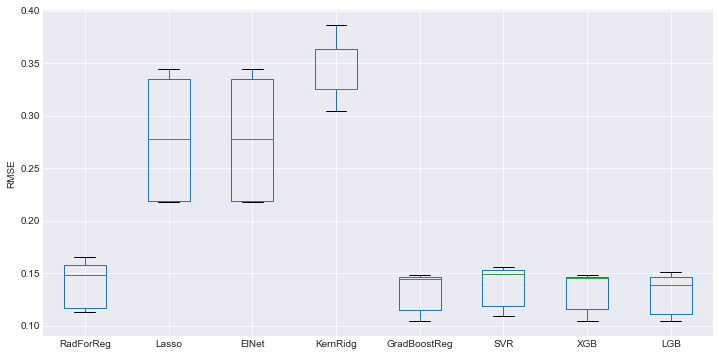

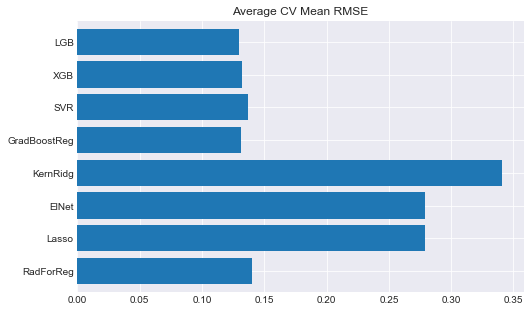

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(train[features].values)
y_train = np.array(train["Power"])
X_test = scaler.transform(test_[features].values)
y_test = np.array(test_["Power"])


kfold = KFold(n_splits=5, random_state=1337) # k=10, split the data into 10 equal parts
xyz = []
rmse = []
std = []
classifiers = ['RadForReg', 'Lasso', 'ElNet', 'KernRidg',
               'GradBoostReg', 'SVR', 'XGB', 'LGB']
models = [RandomForestRegressor(),
          Lasso(),
          ElasticNet(),
          KernelRidge(),
          GradientBoostingRegressor(),
          SVR(),
          xgb.XGBRegressor(),
          lgb.LGBMRegressor()
          ]

for i, model in enumerate(models):
    print("Training "+classifiers[i])
    cv_result = cross_val_score(model, X_train, y_train,
                                cv=kfold, scoring="neg_mean_squared_error")
    cv_result = np.sqrt(-cv_result)
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    rmse.append(cv_result)
models_df = pd.DataFrame({'CV Mean': xyz, 'Std': std}, index=classifiers)     
print models_df

plt.subplots(figsize=(12, 6))
box=pd.DataFrame(rmse, index=[classifiers])
box.T.boxplot()
plt.ylabel('RMSE')
plt.show()

plt.figure()
models_df['CV Mean'].plot.barh(width=0.8)
plt.title('Average CV Mean RMSE')
fig = plt.gcf()
fig.set_size_inches(8,5)
plt.show()        

LGB validation score: 0.12909685132691412
XGB validation score: 0.1306025935419911
Stacked Model validation score: 0.12890184918196362
Stacked Model test score: 0.1200472078173863


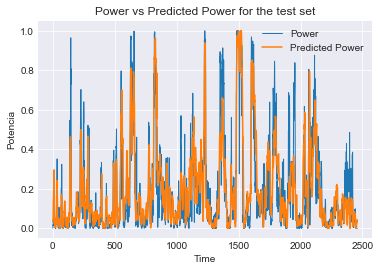

In [9]:
num_iter = 200
init_points = 10

def lgboostcv(num_leaves,
              n_estimators,
              max_depth,
              min_data_in_leaf,                
              silent=True,
              nthread=-1):
    return cross_val_score(lgb.LGBMRegressor(num_leaves=int(num_leaves),
                                             n_estimators=int(n_estimators),
                                             max_depth=int(max_depth),
                                             min_data_in_leaf=int(min_data_in_leaf),                
                                             silent=silent,
                                             nthread=-nthread),
                           X_train,
                           y_train,
                           scoring="neg_mean_squared_error",
                           cv=5).mean()

# Load data set and target values 
lgboostBO = BayesianOptimization(lgboostcv,
                                 {'num_leaves': (5, 2500),
                                  'n_estimators': (10, 2500),
                                  'max_depth': (2, 65),
                                  'min_data_in_leaf': (1, 100),
                                  })

#lgboostBO.maximize(init_points=init_points, n_iter=num_iter)
params = lgboostBO.res['max']['max_params']

# Best model parameters found via Bayesian Optimization
if id == '04':
    params = {'max_depth': 14, 'min_data_in_leaf': 98,
              'n_estimators': 297, 'num_leaves': 7}
elif id == '51':
    params = {'max_depth': 63, 'min_data_in_leaf': 2,
              'n_estimators': 144, 'num_leaves': 7}

params['max_depth'] = int(params['max_depth'])
params['n_estimators'] = int(params['n_estimators'])
params['num_leaves'] = int(params['num_leaves'])
params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
model1 = lgb.LGBMRegressor(**params)
rmse = np.sqrt(-cross_val_score(model1, X_train, y_train,
               cv=5, scoring="neg_mean_squared_error").mean())
print('LGB validation score: '+str(rmse))

def xgboostcv(max_depth,
              n_estimators,
              gamma,
              min_child_weight,
              subsample,
              colsample_bytree,
              reg_alpha,
              reg_lambda,
              silent=True,
              nthread=-1):
    return cross_val_score(xgb.XGBRegressor(max_depth=int(max_depth),
                                            n_estimators=int(n_estimators),
                                            gamma=gamma,
                                            min_child_weight=min_child_weight,
                                            subsample=subsample,
                                            colsample_bytree=colsample_bytree,
                                            reg_alpha=reg_alpha,
                                            reg_lambda=reg_lambda,
                                            silent=silent,
                                            nthread=-1),
                           X_train,
                           y_train,
                           scoring="neg_mean_squared_error",
                           cv=5).mean()

# Load data set and target values
xgboostBO = BayesianOptimization(xgboostcv,
                                 {'max_depth': (3, 15),
                                  'n_estimators': (50, 2500),
                                  'gamma': (0.01, 1),
                                  'min_child_weight': (1, 20),
                                  'subsample': (0.5, 1),
                                  'colsample_bytree': (0.1, 0.99),
                                  'reg_alpha': (0.001, 1),
                                  'reg_lambda': (0.001, 1)                                
                                  })

#xgboostBO.maximize(init_points=init_points, n_iter=num_iter)
params = xgboostBO.res['max']['max_params']

#Best model parameters found via Bayesian Optimization
if id == '04':
    params = {'colsample_bytree': 0.8896392160841922,
             'gamma': 0.12849945329026452,
             'max_depth': 3,
             'min_child_weight': 2,
             'n_estimators': 1591,
             'reg_alpha': 0.9655853324339836,
             'reg_lambda': 0.004081715901799331,
             'subsample': 0.6408693384852601}
elif id == '51':
    params = {'colsample_bytree': 0.977159105263364,
             'gamma': 0.02114708119988647,
             'max_depth': 3,
             'min_child_weight': 1,
             'n_estimators': 302,
             'reg_alpha': 0.31359110474147506,
             'reg_lambda': 0.6505222437581337,
             'subsample': 0.8977404913379465}

params['max_depth'] = int(params['max_depth'])
params['n_estimators'] = int(params['n_estimators'])
params['min_child_weight'] = int(params['min_child_weight'])
model2 = xgb.XGBRegressor(**params)
rmse = np.sqrt(-cross_val_score(model2, X_train, y_train,
                                cv=5,
                                scoring="neg_mean_squared_error").mean())
print('XGB validation score: '+str(rmse))

# Model stacking
#for w in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55,
#          0.60, 0.65, 0.70, 0.75, 0.8, 0.85, 0.9]:
#    model = AveragingModels(models=(model1, model2), weight=w)
#    rmse = np.sqrt(-cross_val_score(model, X_train, y_train,
#                                    cv=10,
#                                    scoring="neg_mean_squared_error").mean())
#   print(w, rmse)

# Best weights found for model stacking
if id == '04':
    model = AveragingModels(models=(model1, model2), weight=0.75)
elif id == '51':
    model = AveragingModels(models=(model1, model2), weight=0.5)

rmse = np.sqrt(-cross_val_score(model, X_train, y_train,
                                   cv=10,
                                    scoring="neg_mean_squared_error").mean())
print('Stacked Model validation score: '+str(rmse))

# Model final evaluation
model.fit(X_train, y_train)
pred = model.predict(X_test)
pred[pred >  1] = 1
pred[pred < 0] = 0
rmse = np.sqrt(mean_squared_error(pred, y_test))
print('Stacked Model test score: '+str(rmse))

plt.figure()
plt.plot(range(len(y_test)), y_test, linewidth=1)
plt.plot(range(len(pred)), pred)
plt.xlabel('Time')
plt.ylabel('Potencia')
plt.legend(['Power', 'Predicted Power'])
plt.title('Power vs Predicted Power for the test set')
plt.show()

In [10]:
X_test = test[features]
X_test = scaler.transform(X_test)
pred = model.predict(X_test)
pred[pred >  1] = 1
pred[pred < 0] = 0
pred = pred*max_power

test['Power'] = pred
test[['predictiondate','Power']].to_csv('data/id_'+id+'_prediction.csv',
                                        index=False, sep=';')

In [12]:
# Model final evaluation
model1.fit(X_train, y_train)
pred = model1.predict(X_test)
pred[pred >  1] = 1
pred[pred < 0] = 0
pred = pred*max_power
test['Power'] = pred
test[['predictiondate','Power']].to_csv('data/id_'+id+'_lgbm.csv',
                                        index=False, sep=';')

# Model final evaluation
model2.fit(X_train, y_train)
pred = model2.predict(X_test)
pred[pred >  1] = 1
pred[pred < 0] = 0
pred = pred*max_power
test['Power'] = pred
test[['predictiondate','Power']].to_csv('data/id_'+id+'_xgb.csv',
                                        index=False, sep=';')

# Model final evaluation
model.fit(X_train, y_train)
pred = model.predict(X_test)
pred[pred >  1] = 1
pred[pred < 0] = 0
pred = pred*max_power
test['Power'] = pred
test[['predictiondate','Power']].to_csv('data/id_'+id+'_stacked.csv',
                                        index=False, sep=';')
